THIS NOTEBOOK IS ORIGINALLY FROM:
https://github.com/JoomiK/ChangePointAnalysis
https://joomik.github.io/mining/

## Mining disasters

This project uses data from a time series of recorded coal mining disasters in the UK from 1851 to 1962. Sometime during this period, new legislation was passed that changed safety regulations. The number of disasters is thought to have gone done because of these changes, but we don't know for sure when this change-point (switchpoint) occurred.

Here I go through a tutorial to estimate when the change-point occurred, and the rate of disasters before and after the change-point, using PYMC3. There will be a lot of annotations to explain what the code is doing.

In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pymc3 import DiscreteUniform, Poisson, Exponential
from pymc3.math import switch
from pymc3 import Metropolis, NUTS, sample, Model, traceplot
from pymc3 import summary
sns.set_style("darkgrid")
sns.set_context("poster")

Text(0.5, 0, 'Year')

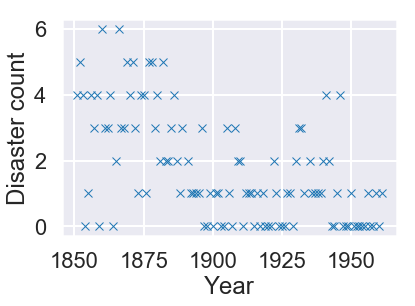

In [12]:
# The data
disaster_data = np.ma.masked_values(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
     3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
     2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
     1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
     0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
     3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
     0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)

plt.plot(year, disaster_data, 'x', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year")

The plot of disasters over time seems to show that the change-point occurred sometime in the early 1900s.

### Specifying the model

We can model the occurrences of disasters with a Poisson, with an early rate for the early part of the time series, and a later (smaller) rate for the later part.

For the year in which the switchpoint occurred, we are just using a uniform distribution from the beginning to the end of the period (this is a rather "diffuse" prior that does not give the model much information on when the switchpoint is thought to have occurred).

In [13]:
# Specifying the model
with Model() as disaster_model:
    # Discrete uniform prior for the switchpoint
    switchpoint = DiscreteUniform('switchpoint', lower=year.min(), upper=year.max())

    # Exponential priors for pre- and post-switch rates
    early_rate = Exponential('early_rate', 1)
    late_rate = Exponential('late_rate', 1)
    
    # <switch> in PYMC3 works like an if statement
    # it uses the first argument (switchpoint) to 
    # switch between the next two arguments.
    #
    # Allocate appropriate Poisson rates to years before and after the current
    rate = switch(switchpoint >= year, early_rate, late_rate) 
    disasters = Poisson('disasters', rate, observed=disaster_data)

/usr/local/lib/python3.7/site-packages/pymc3/model.py:1331: UserWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)


The Model() object is a container for the model random variables.

All statements indented after the 'with' statement specify the components of the model.

We have several stochastic variables here, with Poisson, discrete-uniform, and exponential priors. They are stochastic because their values are partly random.

We also have a deterministic random variable (rate). "Deterministic" (as opposed to stochastic) means that its value is completely determined by its parents' values. 

### Obtain posterior estimates

In [14]:
with disaster_model:
    trace = sample(10000) # draw 10000 posterior samples. 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains: 100%|██████████| 42000/42000 [01:24<00:00, 499.73draws/s] 
The number of effective samples is smaller than 10% for some parameters.


The 'sample' function runs the step method (a particular MCMC sampling algorithm). These can be assigned manually or assigned automatically by PYMC3.

-Binary variables will be assigned to BinaryMetropolis

-Discrete variables will be assigned to Metropolis

-Continuous variables will be assigned to NUTS

It returns a trace object, containing the samples collected.

### Posterior analysis

Let's look at the output from the sampling.

The left column: a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable. The right column: the samples of the Markov chain plotted in order.

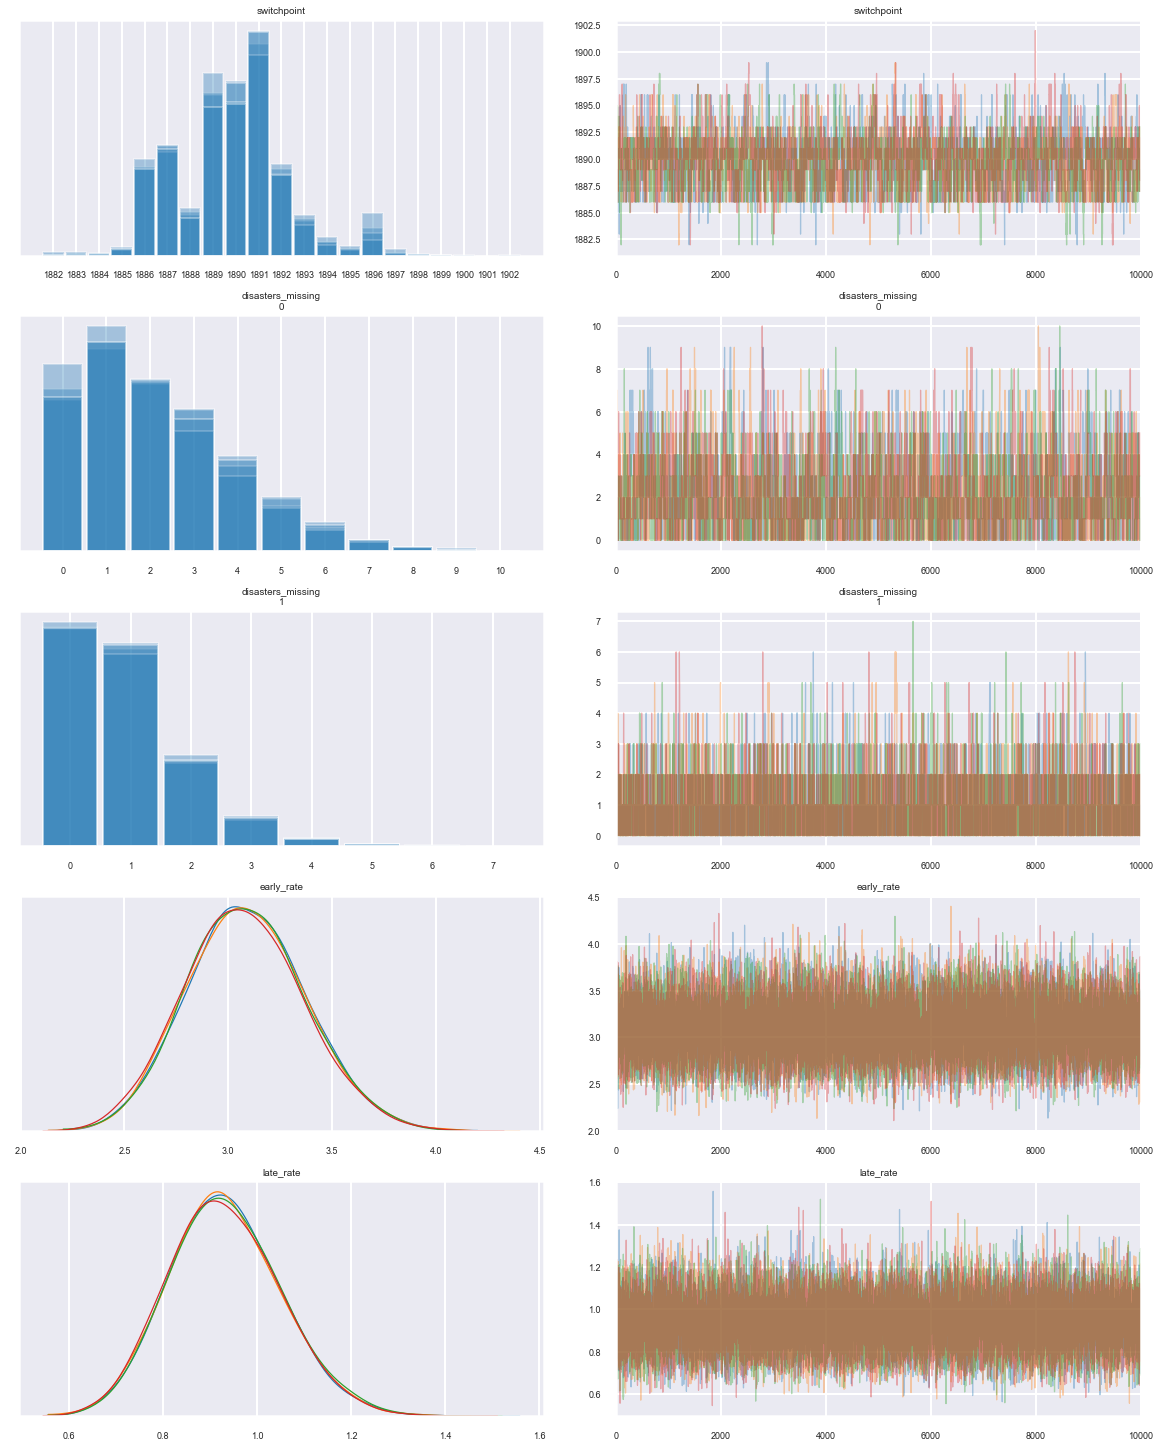

In [21]:
# Look at the posterior plot
traceplot(trace, textsize=9, figsize=(16, 4 * 5));

There is about a 10 year span that's credible for our switchpoint, though it looks like most of the probability mass is over a 5 year span around the early 1890s- this is our interval estimate of when the switchpoint occurred.

### Posterior statistics

We can also get an output of some common posterior statistics.

In [22]:
summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
switchpoint,1889.774775,2.402790,0.058188,1885.000000,1894.000000,1594.284126,1.002902
disasters_missing__0,2.115075,1.757678,0.044960,0.000000,5.000000,1571.000689,1.002225
disasters_missing__1,0.922025,0.991057,0.016631,0.000000,3.000000,3725.239278,0.999958
early_rate,3.088108,0.283175,0.002063,2.543473,3.649263,19528.952921,1.000372
late_rate,0.932662,0.117290,0.000855,0.707250,1.163940,20567.931995,1.000133


We estimate that the switchpoint occurred between 1884 and 1894- this is the highest posterior density interval.

The early rate of disasters was about 3.09/year. It went down to about .93/year after the switchpoint.